# Статистика, DS-поток
## Задание SP.13

**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds23_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. Дождитесь подтверждения от бота, что он принял файл. Если подтверждения нет, то что-то не так. **Работы, присланные иным способом, не принимаются.**
* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания получат штраф.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.
* **Код из рассказанных на занятиях ноутбуков** можно использовать без ограничений.



**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.


**Баллы за задание.**


Практика:
* Задача P1 &mdash; 70 баллов;
* Задача P2 &mdash; 70 баллов.

**Важность задач:**

* *высокая:* все задачи :)

In [1]:
# Bot check

# HW_ID: ds_sp13
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [64]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', palette='Set2')

import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision import models
from torch.utils.data import random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

import time
from collections import defaultdict
from IPython.display import clear_output
from tqdm.notebook import tqdm

---
### Задача P1.


На семинаре мы рассмотрели различные подходы к калибровке классификационных моделей. Но помимо этого хочется иметь метрики калибровки для сравнения качества полученных моделей.

Сгенерируем выборку, в которой классы не являются линейно-разделимыми, а также добавим к ней фоновый шум из точек разных классов.

Используйте функцию `make_blobs`.

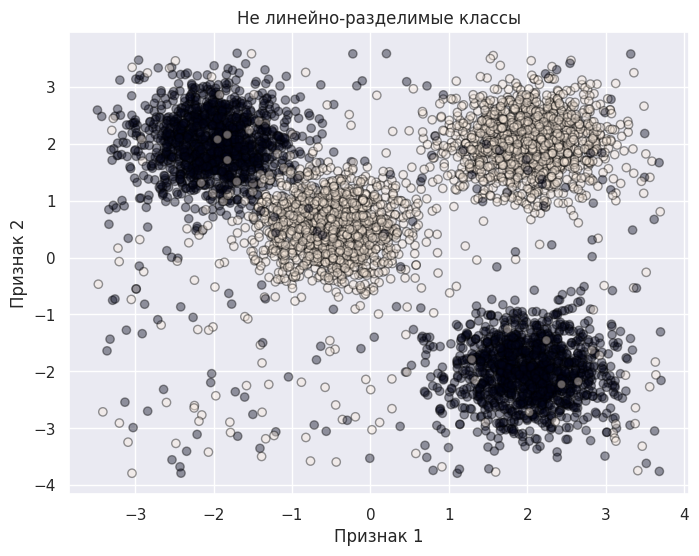

In [3]:
from sklearn.datasets import make_blobs


X_1, y_1 = make_blobs(n_samples=2500, centers=[(-0.5, 0.5), (2, 2)], cluster_std=0.5)
X_0, y_0 = make_blobs(n_samples=2500, centers=[(2, -2), (-2, 2)], cluster_std=0.5)

X = np.vstack([X_0, X_1])
y = np.hstack([np.zeros(len(X_0)), np.ones(len(X_1))])

n_noise = 350

noise_X = np.random.uniform(low=np.min(X, axis=0), high=np.max(X, axis=0), size=(n_noise, X.shape[1]))
noise_y = np.random.randint(0, 2, size=n_noise)

X = np.vstack((X, noise_X))
y = np.hstack((y, noise_y))

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.4, edgecolor='k')
plt.title("Не линейно-разделимые классы")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.show()

Разделите выборку на обучение, валидацию и тест.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2)

Обучите любые три классификационные модели на данных, выведите их метрики.

Инициализация

In [5]:
param_grids = {
    "Random Forest": {
        'n_estimators': np.arange(200, 500, 50),
        'max_depth': np.arange(3, 25, 2),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "Gradient Boosting": {
        'n_estimators': np.arange(200, 500, 50),
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'max_depth': [3, 5, 10],
    },
    "Logistic Regression": {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2']
    }
}

models = {
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression()
}

Обучение

In [6]:
results = {}
best_models = {}

for model_name, model in models.items():
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[model_name],
        n_iter=10,
        cv=5,
        n_jobs=-1,
        random_state=42,
        scoring='f1'
    )
    
    random_search.fit(X_train, y_train)
    
    best_model = random_search.best_estimator_
    
    y_val_pred = best_model.predict(X_val)
    
    results[model_name] = {
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1 Score": f1_score(y_val, y_val_pred)
    }
    best_models[model_name] = random_search.best_estimator_

results = pd.DataFrame(results).T.round(2)
results

,Accuracy,Precision,Recall,F1 Score
Random Forest,0.96,0.96,0.97,0.96
Gradient Boosting,0.96,0.95,0.98,0.96
Logistic Regression,0.68,0.75,0.56,0.64


Отрисуйте калибровочные кривые и гистограммы предсказаний данных моделей. Какие выводы можно сделать?

(0.0, 1.0, 0.0, 1.0)

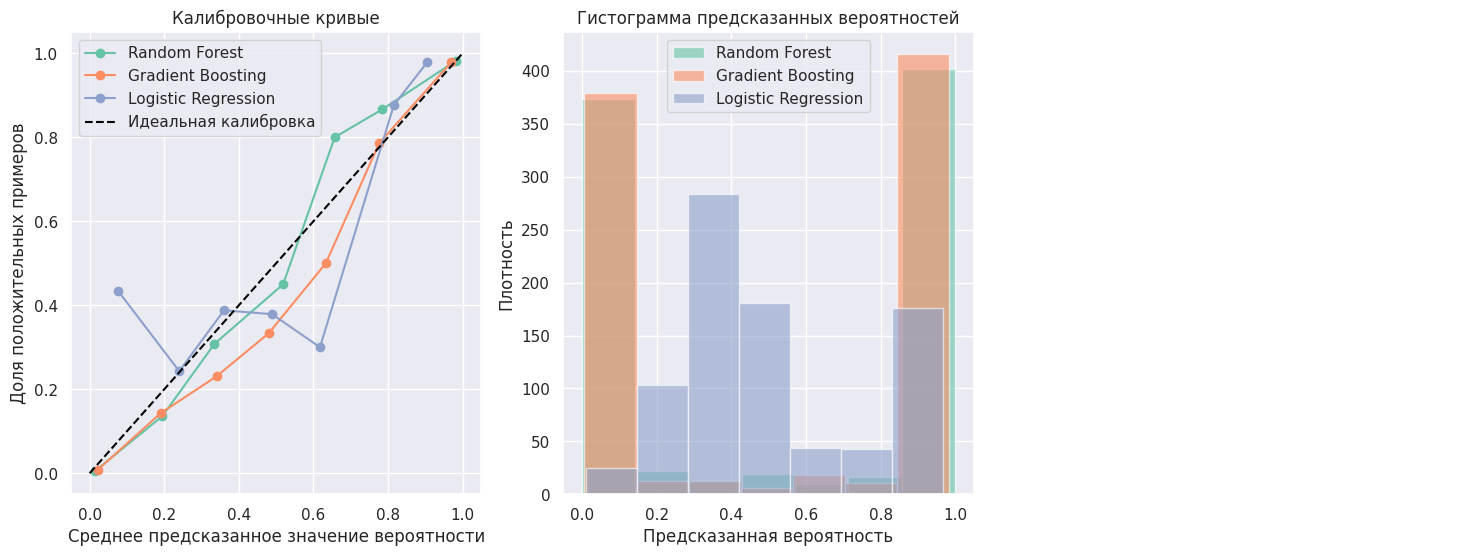

In [7]:
from sklearn.calibration import calibration_curve

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

results = {}

for model_name, model in best_models.items():
    y_val_prob = model.predict_proba(X_val)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val,
                                                                    y_val_prob,
                                                                    n_bins=7)
    
    axes[0].plot(mean_predicted_value,
                 fraction_of_positives,
                 marker='o', label=model_name)
    
    axes[1].hist(y_val_prob, bins=7, alpha=0.6, label=model_name)

axes[0].plot([0, 1], [0, 1], linestyle='--', color='k', label="Идеальная калибровка")

axes[0].set_title("Калибровочные кривые")
axes[0].set_xlabel("Среднее предсказанное значение вероятности")
axes[0].set_ylabel("Доля положительных примеров")
axes[0].legend()

axes[1].set_title("Гистограмма предсказанных вероятностей")
axes[1].set_xlabel("Предсказанная вероятность")
axes[1].set_ylabel("Плотность")
axes[1].legend()
axes[2].axis('off')

Логрегрессия не уверена в предсказании и скорее завышает вероятность класса 1 - что логично, она плохо приближает зависимость (и сильно завышает ее при совсем неверных случаях); остальные две модели уверены в предсказаниях и дают 0-1  - и в у них в целом хорошие калибровочные прямые

Откалибруйте модели. И посмотрите на кривые для новых моделей. Сделайте выводы.

In [8]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_models = {}

for model_name, model in best_models.items():
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    calibrated_model.fit(X_val, y_val)
    calibrated_models[model_name] = calibrated_model

Теперь кривые

(0.0, 1.0, 0.0, 1.0)

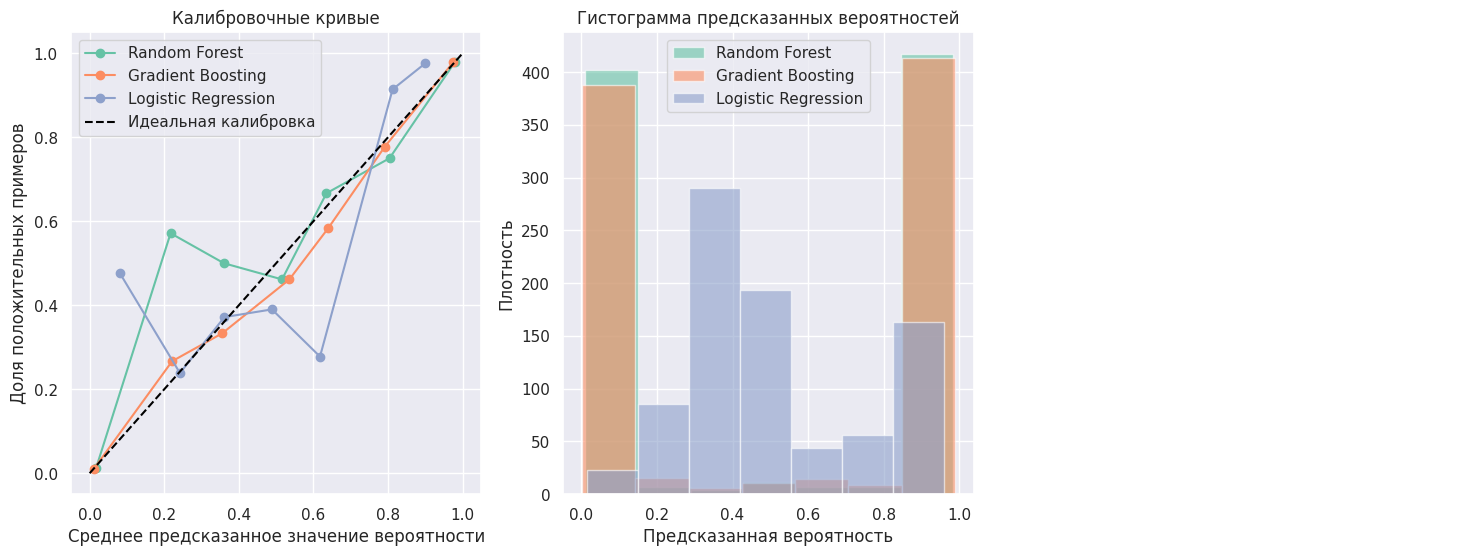

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

results = {}

for model_name, model in calibrated_models.items():
    y_val_prob = model.predict_proba(X_val)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_val,
                                                                    y_val_prob,
                                                                    n_bins=7)
    
    axes[0].plot(mean_predicted_value,
                 fraction_of_positives,
                 marker='o', label=model_name)
    
    axes[1].hist(y_val_prob, bins=7, alpha=0.6, label=model_name)

axes[0].plot([0, 1], [0, 1], linestyle='--', color='k', label="Идеальная калибровка")

axes[0].set_title("Калибровочные кривые")
axes[0].set_xlabel("Среднее предсказанное значение вероятности")
axes[0].set_ylabel("Доля положительных примеров")
axes[0].legend()

axes[1].set_title("Гистограмма предсказанных вероятностей")
axes[1].set_xlabel("Предсказанная вероятность")
axes[1].set_ylabel("Плотность")
axes[1].legend()
axes[2].axis('off')

Теперь калибровочные прямые ближе к идеальной; для логрегресси это улучшение видно на маленьких предсказаниях

---

Для оценки калибровки используются, как правило, две метрики:
- Expected Callibration Error
- Brier Score

**Expected Callibration Error**

Данная метрика наследует идеи гистограммной калибровки. Пусть $B_1, \dots, B_k$ &mdash; разбиение отрезка $[0, 1]$ на непересекающиеся бины.

$$ECE = \sum_{j = 1}^k \cfrac{\sum_{i=1}^n I\{x_i \in B_j\}}{n} \left|\overline{y}(B_j) - \overline{p}(B_j)\right|$$

**Brier Score**

Данный подход ближе к изотонической регрессии.
$$BS = \sum_{i=1}^n (y_i - p(x_i))^2.$$
Причем в качестве функции разницы рассматривают не только квадратичную ошибку.

---

Реализуйте функции для подстчета метрик:

In [10]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Рассчитывает ECE.
    
    :param y_true: истинные метки (y)
    :param y_prob: предсказанные вероятности положительного класса
    :param n_bins: количество бинов для разбиения отрезка [0, 1]
    
    :return: значение ECE
    """
    bins = np.linspace(0, 1, n_bins + 1)
    
    ece = 0
    n = len(y_true)
    
    for i in range(n_bins):
        bin_indices = np.where((y_prob >= bins[i]) & (y_prob < bins[i + 1]))[0]
        
        if len(bin_indices) == 0:
            continue
        
        y_bin = y_true[bin_indices]
        p_bin = y_prob[bin_indices]
        
        mean_true = np.mean(y_bin)
        mean_pred = np.mean(p_bin)
        
        ece += len(bin_indices) * abs(mean_true - mean_pred) / n 
    
    return ece

def brier_score(y_true, y_prob):
    """
    Рассчитывает Brier Score.
    
    :param y_true: истинные метки (y)
    :param y_prob: предсказанные вероятности положительного класса
    
    :return: значение Brier Score
    """
    brier = np.sum((y_true - y_prob) ** 2)
    return brier

def calibrate_model(model, X_val, y_val):
    """
    Калибровка с помощью Platt Scaling затем с помощью Isotonic Regression
    """
    model_platt = CalibratedClassifierCV(model, method='sigmoid', cv='prefit')
    model_platt.fit(X_val, y_val)
    
    model_isotonic = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
    model_isotonic.fit(X_val, y_val)
    
    return model_platt, model_isotonic

Проанализируйте, какой метод калибровки лучше подоходит для каждой из моделей.

In [11]:
calibrated_models = {}
for model_name, model in best_models.items():
    model_platt, model_isotonic = calibrate_model(model, X_val, y_val)
    calibrated_models[model_name] = {
        "Platt Scaling": model_platt,
        "Isotonic Regression": model_isotonic
    }

results_calibration = {}

for model_name, calib_models in calibrated_models.items():
    results_calibration[model_name] = {}
    
    for calib_method, model in calib_models.items():
        y_test_prob = model.predict_proba(X_test)[:, 1]
        
        ece = expected_calibration_error(y_test, y_test_prob, n_bins=20)
        bs = brier_score(y_test, y_test_prob)
        
        results_calibration[model_name][calib_method] = {"ECE": ece, "Brier Score": bs}

for model_name, calib_methods in results_calibration.items():
    print(f"Результаты для модели {model_name}:")
    for calib_method, metrics in calib_methods.items():
        print(f"  {calib_method}:\n ECE = {metrics['ECE']:.5f},\n Brier Score = {metrics['Brier Score']:.2f}")


Результаты для модели Random Forest:
  Platt Scaling:
 ECE = 0.01922,
 Brier Score = 23.10
  Isotonic Regression:
 ECE = 0.00000,
 Brier Score = 20.53
Результаты для модели Gradient Boosting:
  Platt Scaling:
 ECE = 0.01914,
 Brier Score = 24.35
  Isotonic Regression:
 ECE = 0.00000,
 Brier Score = 22.60
Результаты для модели Logistic Regression:
  Platt Scaling:
 ECE = 0.09330,
 Brier Score = 166.04
  Isotonic Regression:
 ECE = 0.00000,
 Brier Score = 153.26


**Вывод:**

Для всех моделей Isotonic Regression дает лучший результат по обеим метрикам

---
### Задача P2.


Исследуем, насколько скалиброванны нейронные сети. Рассмотрим датасет <a href="https://www.kaggle.com/datasets/chetankv/dogs-cats-images">Dogs & Cats Images</a>. Требуется определить, кто изображен на картинке &mdash; собака или кошка.

Выделите из обучающего набора выделите трейн и валидацию в соотношении 3:1.

In [18]:
dataset_path = 'dataset'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(os.path.join(dataset_path,
                                                  'training_set'),
                                     transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(dataset_path,
                                                 'test_set'),
                                    transform=transform)

train_size = int(0.75 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset,
                                          [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32,
                          num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32,
                        num_workers=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32,
                         num_workers=8, shuffle=False)


train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)

print(f"Количество изображений в тренировочном наборе: {train_size}")
print(f"Количество изображений в валидационном наборе: {val_size}")
print(f"Количество изображений в тестовом наборе: {test_size}")

Количество изображений в тренировочном наборе: 6000
Количество изображений в валидационном наборе: 2000
Количество изображений в тестовом наборе: 2000


Постройте простую сверточную нейронную сеть для классификации изображений и обучите ее на тренировочной части данных. Используйте хотя бы несколько сверточных слоев, но слишком много не стоит.

Определение модели

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 2)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Осталось обучить модель. Функция обучения

In [29]:
def train(
    model,
    criterion,
    optimizer,
    train_batch_gen,
    val_batch_gen,
    num_epochs=40
):
    '''
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох

    :return: обученная модель
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    '''

    history = defaultdict(lambda: defaultdict(list))

    for epoch in tqdm(range(num_epochs)):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        start_time = time.time()

        # Устанавливаем поведение dropout / batch_norm  в обучение
        model.train(True)

        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in tqdm(train_batch_gen):
            # Обучаемся на батче (одна "итерация" обучения нейросети)
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты на выходе модели
            logits = model(X_batch)

            # Подсчитываем лосс
            loss = criterion(logits, y_batch.long().to(device))

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

            # Сохраняем лоссы и точность на трейне
            train_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            train_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        train_loss /= len(train_batch_gen)
        train_acc /= len(train_batch_gen)
        history['loss']['train'].append(train_loss)
        history['acc']['train'].append(train_acc)

        # Устанавливаем поведение dropout / batch_norm в режим тестирования
        model.train(False)

        # Полный проход по валидации
        for X_batch, y_batch in val_batch_gen:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            # Логиты, полученные моделью
            logits = model(X_batch)

            # Лосс на валидации
            loss = criterion(logits, y_batch.long().to(device))

            # Сохраняем лоссы и точность на валидации
            val_loss += loss.detach().cpu().numpy()
            y_pred = logits.max(1)[1].detach().cpu().numpy()
            val_acc += np.mean(y_batch.cpu().numpy() == y_pred)

        # Подсчитываем лоссы и сохраняем в "историю"
        val_loss /= len(val_batch_gen)
        val_acc /= len(val_batch_gen)
        history['loss']['val'].append(val_loss)
        history['acc']['val'].append(val_acc)

        clear_output(wait=True)

        # Печатаем результаты после каждой эпохи
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(train_loss))
        print("  validation loss (in-iteration): \t{:.6f}".format(val_loss))
        print("  training accuracy: \t\t\t{:.2f} %".format(train_acc * 100))
        print("  validation accuracy: \t\t\t{:.2f} %".format(val_acc * 100))

    return history

И само обучение

In [58]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SimpleCNN = SimpleCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(SimpleCNN.parameters(), lr=1e-3)

num_epochs = 5
history = train(
    model=SimpleCNN,
    criterion=criterion,
    optimizer=optimizer,
    train_batch_gen=train_loader,
    val_batch_gen=val_loader,
    num_epochs=num_epochs
)

Epoch 5 of 5 took 9.921s
  training loss (in-iteration): 	0.272117
  validation loss (in-iteration): 	0.635959
  training accuracy: 			88.16 %
  validation accuracy: 			72.72 %


Функция для отрисовки графиков обучения

In [31]:
def plot_histories(histories, names):
    '''
    Функция для вывода лосса и метрики во время обучения.
    :param history: (dict) accuracy и loss на обучении и валидации
    :param names: (dict) название модели
    '''
    sns.set_style('darkgrid')
    colors = ['darkblue', 'lightcoral', 'limegreen', 'sandybrown']
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h['loss']['train']) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title('Лосс')
        axs[0].plot(history['loss']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[0].plot(history['loss']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[0].set_xlabel('Эпохи')

        axs[1].set_title('Точность')
        axs[1].plot(history['acc']['train'][:epochs], label=f'{name}', lw=2, c=colors[i])
        axs[1].plot(history['acc']['val'][:epochs], lw=1.5, c=colors[i], ls='--')
        axs[1].set_xlabel('Эпохи')
        axs[1].legend()

    dummy_lines = [axs[0].plot([], [], c='black', lw=2)[0],
                   axs[0].plot([], [], c='black', lw=1.5, ls='--')[0]]
    for i in range(2):
        legend = axs[i].legend(loc=3-i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

График обучения

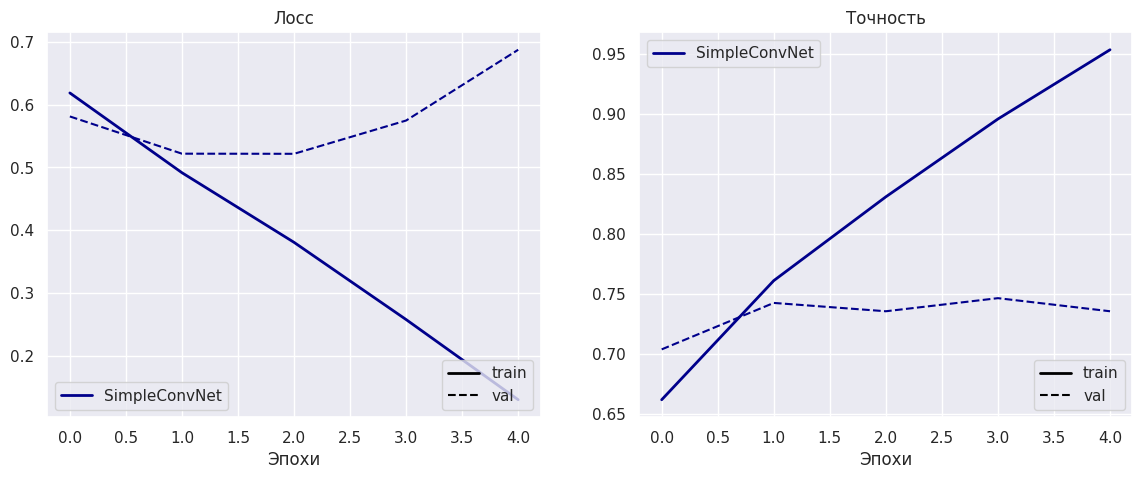

In [32]:
plot_histories([history], ['SimpleConvNet'])

Также выберите один из <a href="https://pytorch.org/vision/stable/models.html">видов архитектруры</a> нейронной сети для классификации изображений из torchvision, например, ResNet. Определите для него 3 варианта архитектуры с разным количеством параметров.

Инициализация моделей

In [41]:
import torchvision.models as models

def get_resnet_model(variant):
    if variant == "resnet18":
        model = models.resnet18(pretrained=True)
    elif variant == "resnet34":
        model = models.resnet34(pretrained=True)
    elif variant == "resnet50":
        model = models.resnet50(pretrained=True)
    
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 2)
    return model

resnet18 = get_resnet_model("resnet18").to(device)
resnet34 = get_resnet_model("resnet34").to(device)
resnet50 = get_resnet_model("resnet50").to(device)

Обучим первую

In [45]:
optimizer = torch.optim.Adam(resnet18.parameters(), lr=1e-3)

history_resnet18 = train(
    model=resnet18,
    criterion=criterion,
    optimizer=optimizer,
    train_batch_gen=train_loader,
    val_batch_gen=val_loader,
    num_epochs=num_epochs
)

Epoch 5 of 5 took 10.759s
  training loss (in-iteration): 	0.066441
  validation loss (in-iteration): 	0.277326
  training accuracy: 			97.92 %
  validation accuracy: 			91.47 %


Вторую

In [46]:
optimizer = torch.optim.Adam(resnet34.parameters(), lr=1e-3)

history_resnet34 = train(
    model=resnet34,
    criterion=criterion,
    optimizer=optimizer,
    train_batch_gen=train_loader,
    val_batch_gen=val_loader,
    num_epochs=num_epochs
)

Epoch 5 of 5 took 12.200s
  training loss (in-iteration): 	0.055248
  validation loss (in-iteration): 	0.272244
  training accuracy: 			98.02 %
  validation accuracy: 			91.52 %


Третью

In [47]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr=1e-3)

history_resnet50 = train(
    model=resnet50,
    criterion=criterion,
    optimizer=optimizer,
    train_batch_gen=train_loader,
    val_batch_gen=val_loader,
    num_epochs=num_epochs
)

Epoch 5 of 5 took 15.284s
  training loss (in-iteration): 	0.104600
  validation loss (in-iteration): 	0.207244
  training accuracy: 			95.84 %
  validation accuracy: 			92.81 %


Построим графики обучения

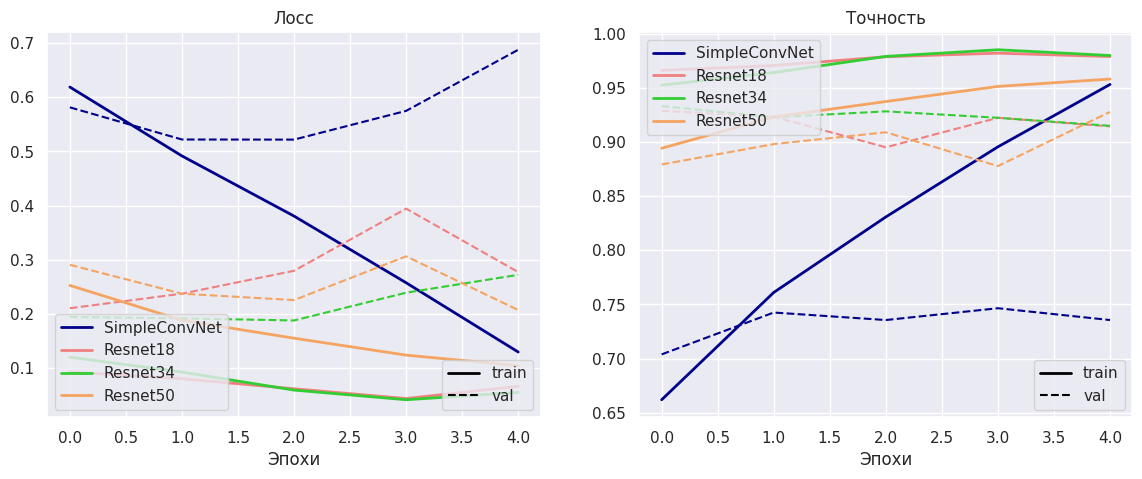

In [48]:
plot_histories([history, history_resnet18, history_resnet34, history_resnet50],
               ['SimpleConvNet', 'Resnet18', 'Resnet34', 'Resnet50'])

Для каждой рассмотренной ранее модели выполните следующие действия.
* Посмотрите на калибровочную кривую и оценку качества калибровки.
* Примените методы калибровки и сравните результаты. Посчитайте, как изменилась точность классификации на тестовой части данных.

Поясните, почему калибровку необходимо выполнять на валидационной части данных, а оценивать точность классификации &mdash; на тестовом.

Вспомогательная функция

In [92]:
def get_predictions_and_probs(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Получение предсказаний"):
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.numpy())
    return np.array(all_probs), np.array(all_labels)

def calibrate_model(y_val_prob, y_val):
    """
    Калибровка с помощью Platt Scaling и Isotonic Regression.
    """
    model_platt = LogisticRegression()
    model_platt.fit(y_val_prob.reshape(-1, 1), y_val)
    
    model_isotonic = IsotonicRegression(out_of_bounds="clip")
    model_isotonic.fit(y_val_prob.reshape(-1, 1), y_val)
    
    return model_platt, model_isotonic

Калибровка

In [93]:
models = {
    "SimpleCNN": SimpleCNN,
    "ResNet18": resnet18,
    "ResNet34": resnet34,
    "ResNet50": resnet50,
}

results_calibration = {}

calibrated_models = {}
for model_name, model in models.items():
    
    y_val_prob, y_val = get_predictions_and_probs(model, val_loader, device)
    
    model_platt, model_isotonic = calibrate_model(y_val_prob, y_val)
    calibrated_models[model_name] = {
        "Platt Scaling": model_platt,
        "Isotonic Regression": model_isotonic
    }

Получение предсказаний:   0%|          | 0/63 [00:00<?, ?it/s]

Получение предсказаний:   0%|          | 0/63 [00:00<?, ?it/s]

Получение предсказаний:   0%|          | 0/63 [00:00<?, ?it/s]

Получение предсказаний:   0%|          | 0/63 [00:00<?, ?it/s]

Исходные калибровочные кривые на валидации

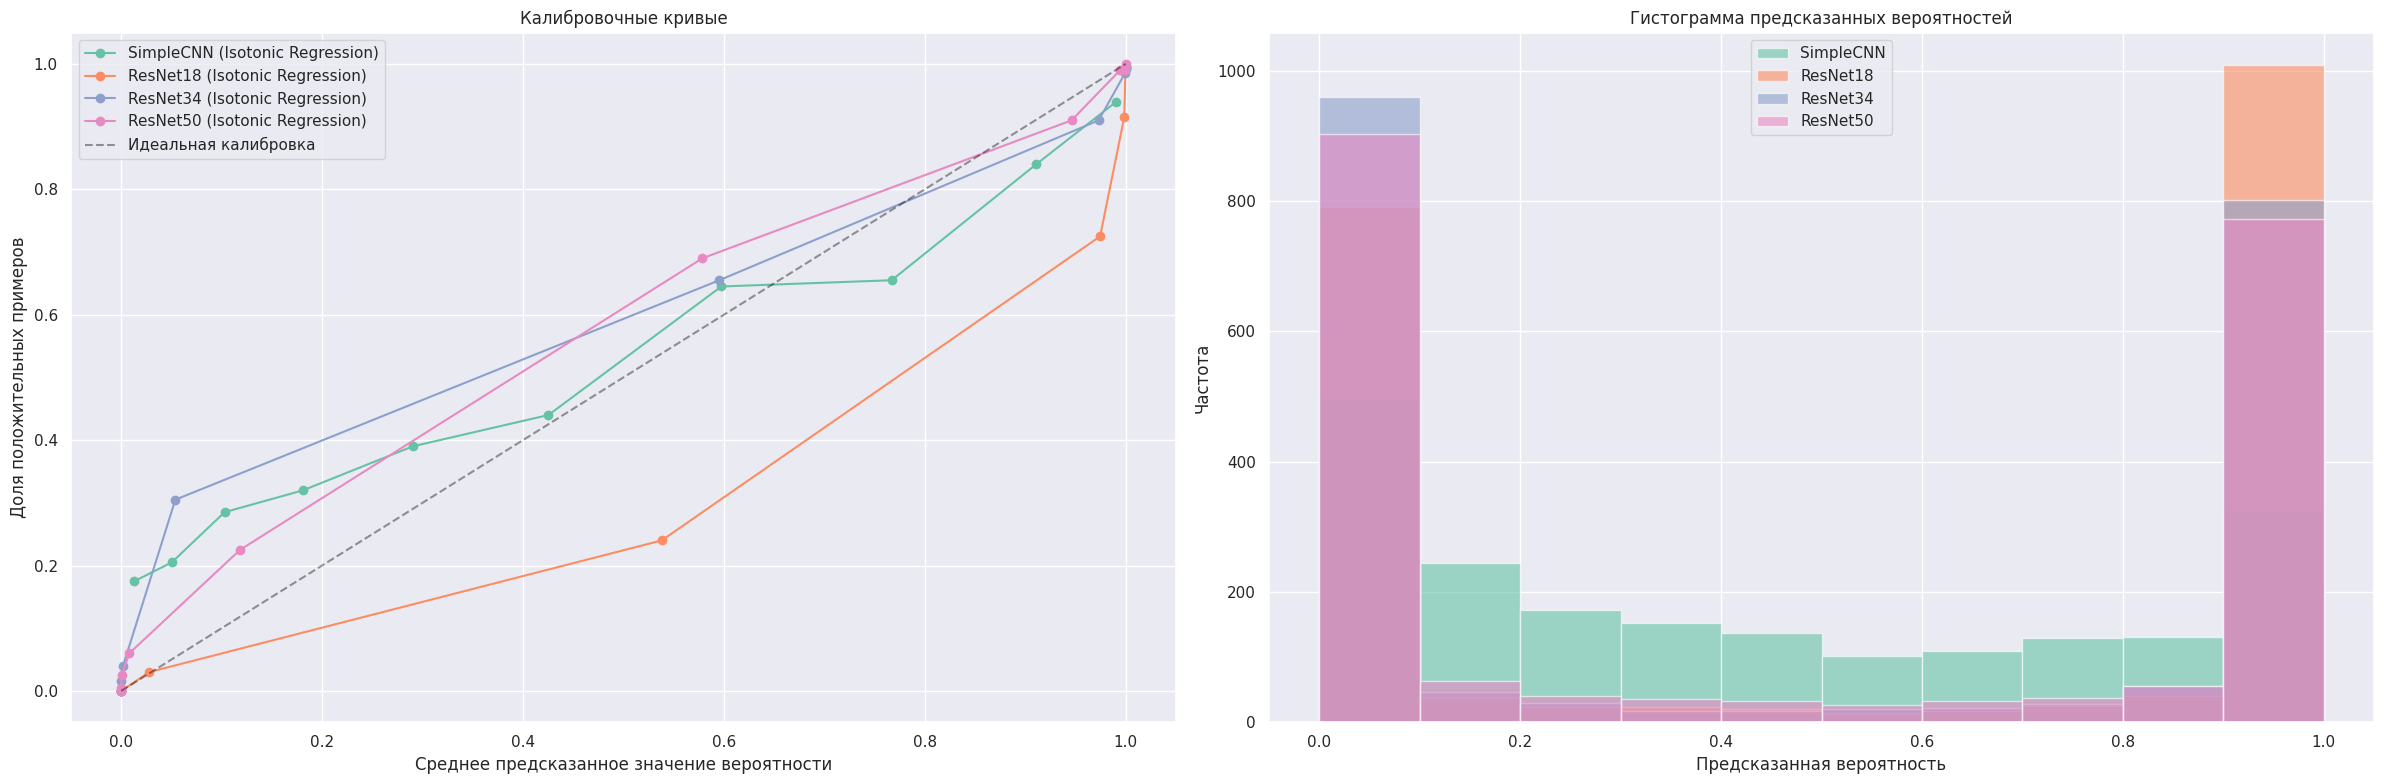

In [96]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for model_name, calib_methods in calibrated_models.items():
    y_val_prob, y_val = get_predictions_and_probs(models[model_name], val_loader, device)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_val, y_val_prob, n_bins=10, strategy='quantile'
    )
        
    axes[0].plot(mean_predicted_value,
                    fraction_of_positives,
                    marker='o', label=f"{model_name} ({calib_method})")
        
    axes[1].hist(y_val_prob, bins=10, alpha=0.6, label=f"{model_name}")

clear_output()
axes[0].plot([0, 1], [0, 1], linestyle='--', alpha=0.4, color='k', label="Идеальная калибровка")
axes[0].set_title("Калибровочные кривые")
axes[0].set_xlabel("Среднее предсказанное значение вероятности")
axes[0].set_ylabel("Доля положительных примеров")
axes[0].legend()

axes[1].set_title("Гистограмма предсказанных вероятностей")
axes[1].set_xlabel("Предсказанная вероятность")
axes[1].set_ylabel("Частота")
axes[1].legend()

plt.tight_layout()
plt.show()


Калибровочные кривые на валидации - очень хорошие

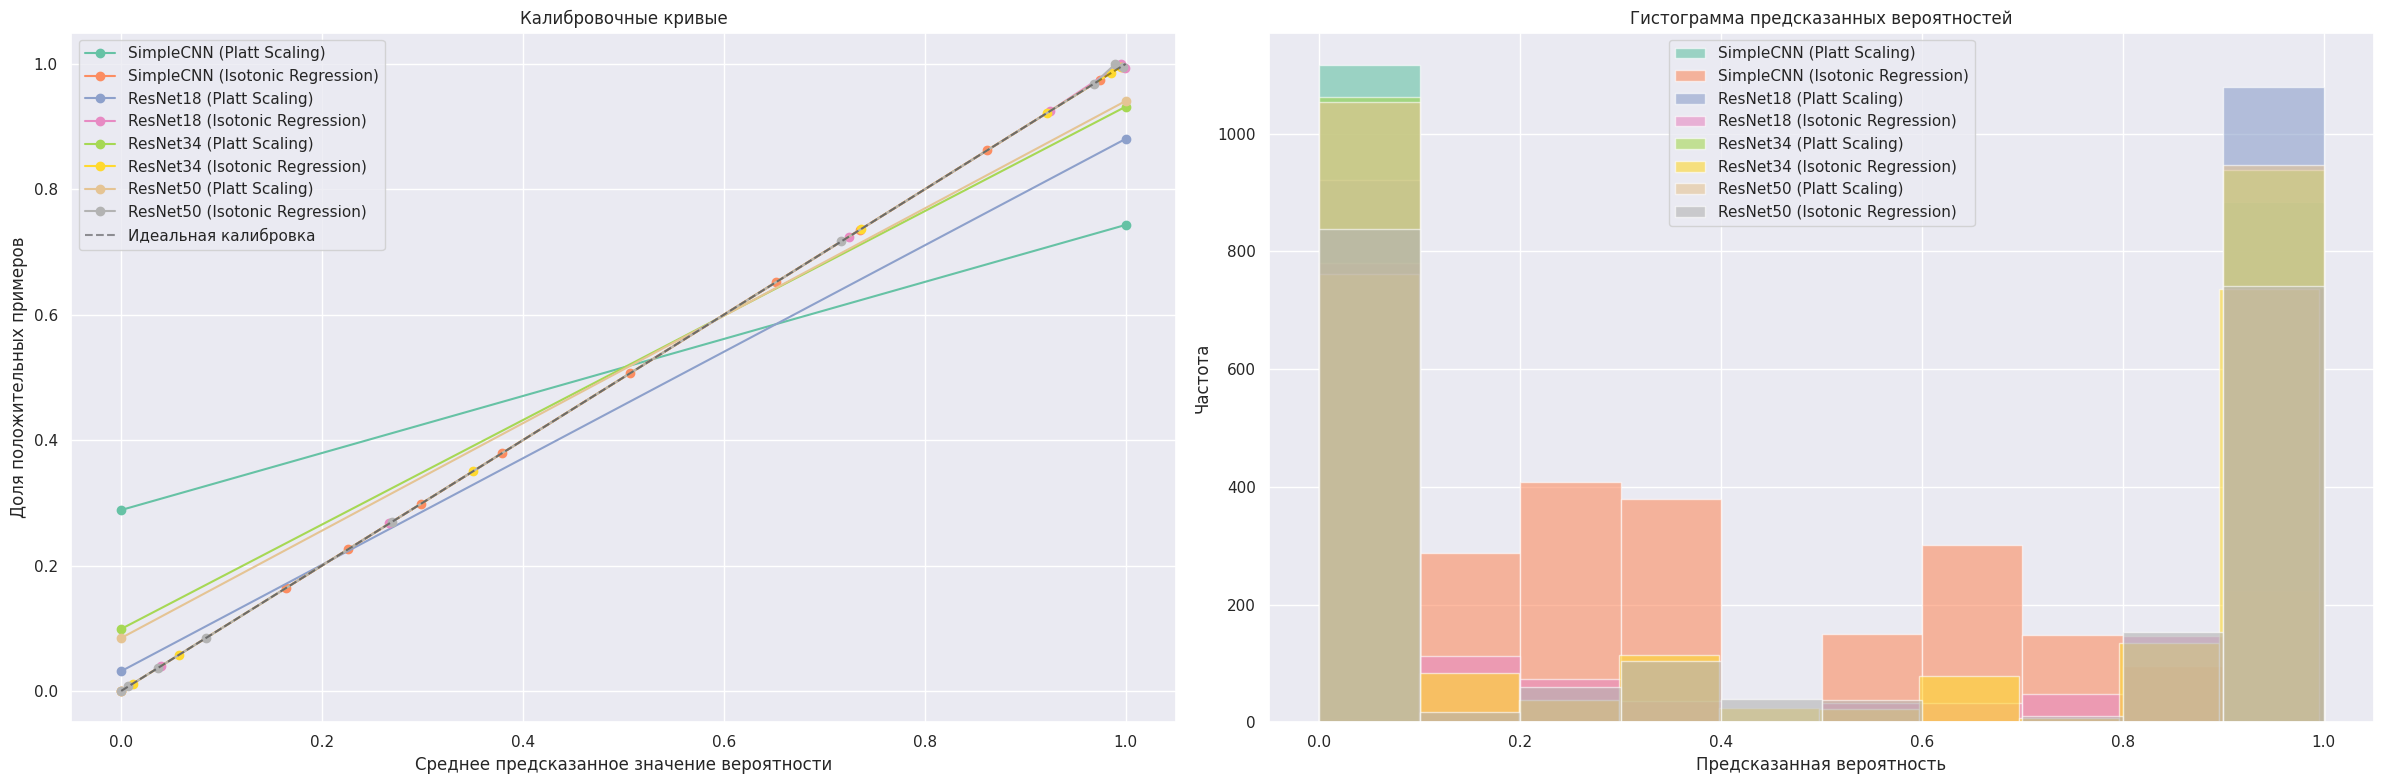

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for model_name, calib_methods in calibrated_models.items():
    y_val_prob, y_val = get_predictions_and_probs(models[model_name], val_loader, device)
    
    for calib_method, calibrated_model in calib_methods.items():
        y_calib_prob = calibrated_model.predict(y_val_prob.reshape(-1, 1))
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_val, y_calib_prob, n_bins=10, strategy='quantile'
        )
        
        axes[0].plot(mean_predicted_value,
                     fraction_of_positives,
                     marker='o', label=f"{model_name} ({calib_method})")
        
        axes[1].hist(y_calib_prob, bins=10, alpha=0.6, label=f"{model_name} ({calib_method})")

clear_output()
axes[0].plot([0, 1], [0, 1], linestyle='--', alpha=0.4, color='k', label="Идеальная калибровка")
axes[0].set_title("Калибровочные кривые")
axes[0].set_xlabel("Среднее предсказанное значение вероятности")
axes[0].set_ylabel("Доля положительных примеров")
axes[0].legend()

axes[1].set_title("Гистограмма предсказанных вероятностей")
axes[1].set_xlabel("Предсказанная вероятность")
axes[1].set_ylabel("Частота")
axes[1].legend()

plt.tight_layout()
plt.show()


Посмотрим что на тесте

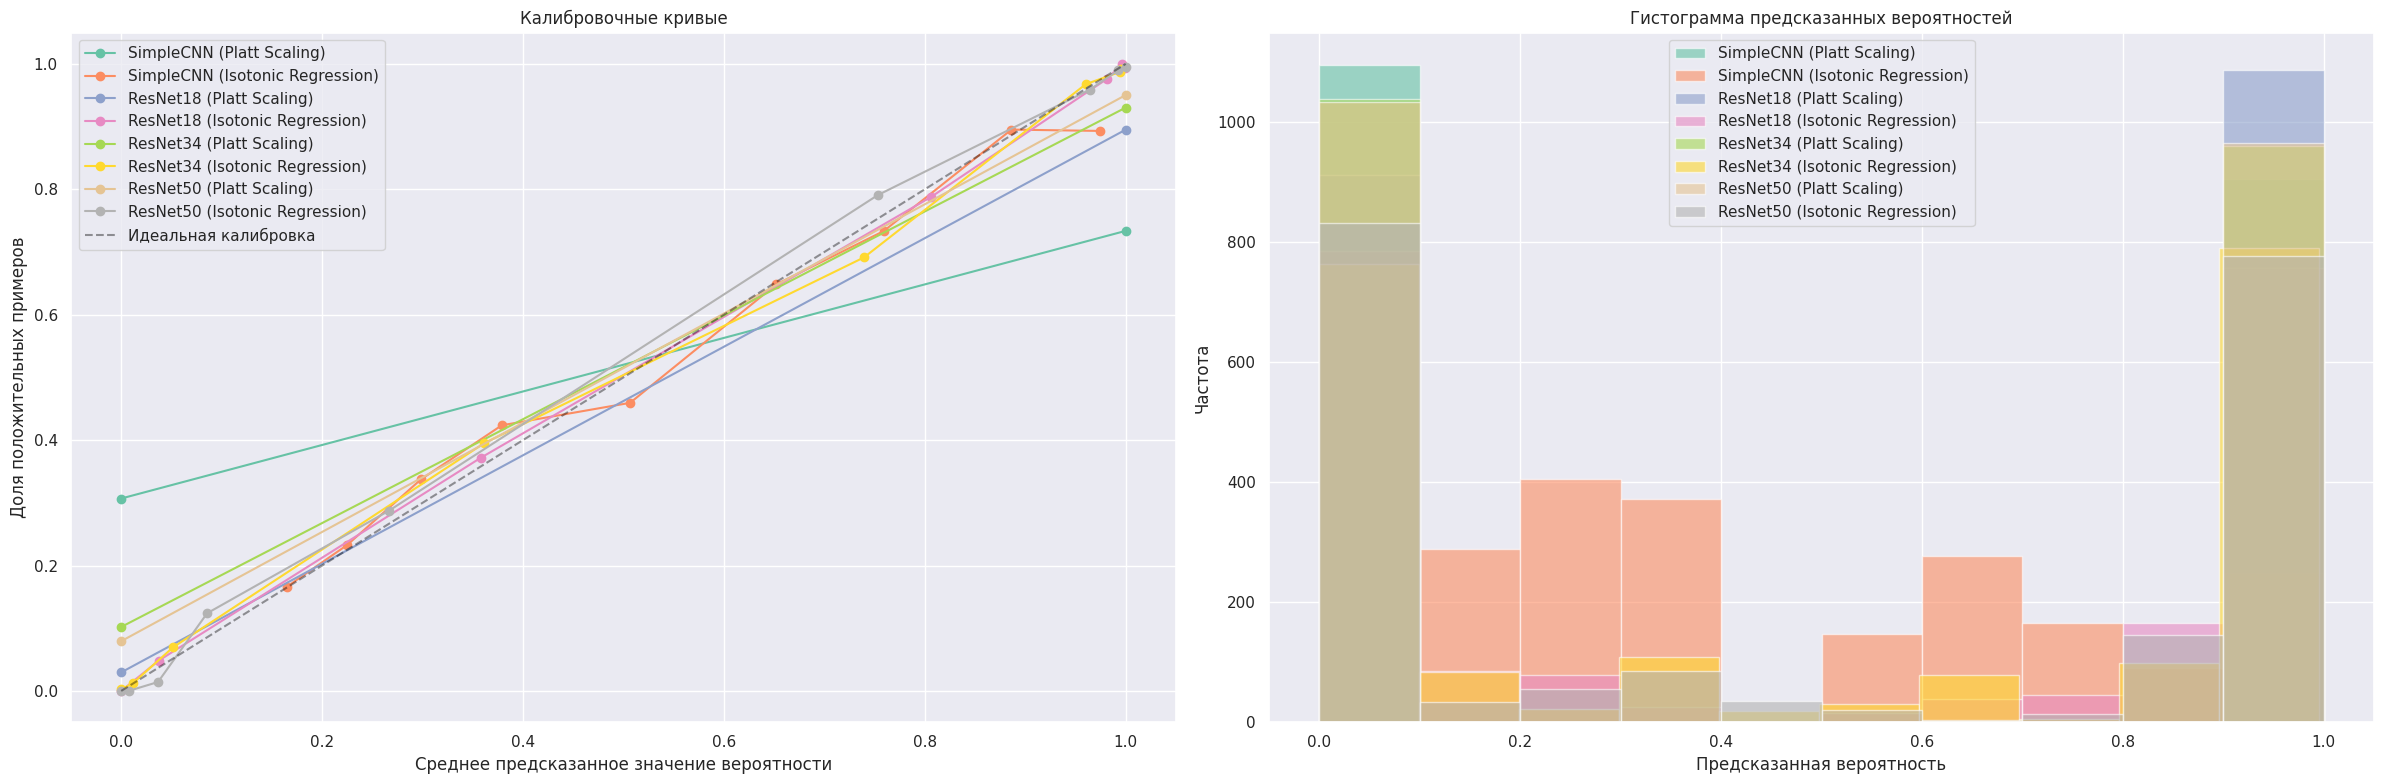

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for model_name, calib_methods in calibrated_models.items():
    y_test_prob, y_test = get_predictions_and_probs(models[model_name], test_loader, device)
    
    for calib_method, calibrated_model in calib_methods.items():
        y_calib_prob = calibrated_model.predict(y_test_prob.reshape(-1, 1))
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_calib_prob, n_bins=10, strategy='quantile'
        )
        
        axes[0].plot(mean_predicted_value,
                     fraction_of_positives,
                     marker='o', label=f"{model_name} ({calib_method})")
        
        axes[1].hist(y_calib_prob, bins=10, alpha=0.6, label=f"{model_name} ({calib_method})")

clear_output()
axes[0].plot([0, 1], [0, 1], linestyle='--', alpha=0.4, color='k', label="Идеальная калибровка")
axes[0].set_title("Калибровочные кривые")
axes[0].set_xlabel("Среднее предсказанное значение вероятности")
axes[0].set_ylabel("Доля положительных примеров")
axes[0].legend()

axes[1].set_title("Гистограмма предсказанных вероятностей")
axes[1].set_xlabel("Предсказанная вероятность")
axes[1].set_ylabel("Частота")
axes[1].legend()

plt.tight_layout()
plt.show()


Рассчет метрик на тестовой части

In [89]:
for model_name, calib_methods in calibrated_models.items():
    results_calibration[model_name]["test"] = {}
    y_test_prob, y_test = get_predictions_and_probs(models[model_name], test_loader, device)
    
    for calib_method, calibrated_model in calib_methods.items():
        if isinstance(calibrated_model, LogisticRegression):
            y_calib_test_prob = calibrated_model.predict_proba(y_test_prob.reshape(-1, 1))[:, 1]
        elif isinstance(calibrated_model, IsotonicRegression):
            y_calib_test_prob = calibrated_model.predict(y_test_prob)
        
        ece = expected_calibration_error(y_test, y_calib_test_prob, n_bins=20)
        bs = brier_score(y_test, y_calib_test_prob)
        
        results_calibration[model_name]["test"][calib_method] = {"ECE": ece, "Brier Score": bs}

clear_output()

for model_name, calib_methods in results_calibration.items():
    print(f"Результаты для модели {model_name} на тестовых данных:")
    for calib_method, metrics in calib_methods["test"].items():
        print(f"  {calib_method}:\n    ECE = {metrics['ECE']:.5f},\n    Brier Score = {metrics['Brier Score']:.5f}")


Результаты для модели SimpleCNN на тестовых данных:
  Platt Scaling:
    ECE = 0.05056,
    Brier Score = 381.60271
  Isotonic Regression:
    ECE = 0.02722,
    Brier Score = 380.68330
Результаты для модели ResNet18 на тестовых данных:
  Platt Scaling:
    ECE = 0.03546,
    Brier Score = 114.49820
  Isotonic Regression:
    ECE = 0.01411,
    Brier Score = 93.85426
Результаты для модели ResNet34 на тестовых данных:
  Platt Scaling:
    ECE = 0.05216,
    Brier Score = 136.34384
  Isotonic Regression:
    ECE = 0.01776,
    Brier Score = 116.22518
Результаты для модели ResNet50 на тестовых данных:
  Platt Scaling:
    ECE = 0.03205,
    Brier Score = 103.48132
  Isotonic Regression:
    ECE = 0.01743,
    Brier Score = 97.70682


Сделайте выводы.

Оценивать калибровку надо на тесте - потому что калибруем на валидации - иначе у нас сильное переобучение, что видно из сравнения калибровочных кривых на валидации в тесте (в первом случае идеальная кривая)

Исходно калибровочные кривые не сильно отстают от идеальной, кроме Resnet18 - она завышает предсказания; SimpleCNN несколько занижает предсказание для маленьких вероятностей

Почти все калибровки приводят к почти идеальной калибровочной прямой на тестовой части

SimpleCNN с Platt Scaling выглядит как несколько переобученная модель (было видно и графике обучения, на лоссе) - почти все предсказания близки к 0 или 1 - поэтому калибровочная прямая выглядит так странно (две точки, в промежуточные бины просто больше ничего особо не попадает)

С помощью калибровки мы можем сделать модель более интерперитируемой и улучшить ее качество